In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import padasip as pa

In [2]:
# class FilterNLMS(pa.filters.base_filter.AdaptiveFilter):
# This is a function they removed from the main branch of the library
class AdaptiveFilter(pa.filters.base_filter.AdaptiveFilter):
    def explore_learning(self, d, x, mu_start=0, mu_end=1., steps=100, ntrain=0.5, epochs=1, criteria="MSE", target_w=False):
        mu_range = np.linspace(mu_start, mu_end, steps)
        errors = np.zeros(len(mu_range))
        for i, mu in enumerate(mu_range):
            # init
            self.init_weights("zeros")
            self.mu = mu
            # run
            y, e, w = self.pretrained_run(d, x, ntrain=ntrain, epochs=epochs)
            if type(target_w) != bool:
                errors[i] = self.get_mean_error(w[-1]-target_w, function=criteria)
            else:
                errors[i] = self.get_mean_error(e, function=criteria)
        return errors, mu_range    
    

    def get_valid_error(self, x1, x2=-1):
        if type(x2) == int and x2 == -1:
            try:    
                e = np.array(x1)
            except:
                raise ValueError('Impossible to convert series to a numpy array')        
        # two series
        else:
            try:
                x1 = np.array(x1)
                x2 = np.array(x2)
            except:
                raise ValueError('Impossible to convert one of series to a numpy array')
            if not len(x1) == len(x2):
                raise ValueError('The length of both series must agree.')
            e = x1 - x2
        return e

    def logSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return 10*np.log10(e**2)


    def MAE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sum(np.abs(e)) / float(len(e))

    def MSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.dot(e, e) / float(len(e))

    def RMSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sqrt(np.dot(e, e) / float(len(e)))

    def get_mean_error(self, x1, x2=-1, function="MSE"):
        if function == "MSE":
            return self.MSE(x1, x2)
        elif function == "MAE":
            return self.MAE(x1, x2)
        elif function == "RMSE":
            return self.RMSE(x1, x2)
        else:
            raise ValueError('The provided error function is not known')

In [3]:
data = []
with open('data/series/CAT_dividends.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    reader.__next__()
    for row in reader:
        data.append(float(row[1]))
data = np.array(data)

In [4]:
train = data.reshape(193,1)[:150]
test = data.reshape(193,1)[150:]

In [43]:
x = np.squeeze(pa.input_from_history(train, n)) # Input matrix
N = len(x)
d = np.zeros(N) # Intialize target with empty values

for i, k in enumerate(range((n-1), N)):
    # Fill target with our desired values
    d[i] = train[k+1]

In [76]:
f = AdaptiveFilter(n=n, mu=0)

In [77]:
errors_e, mu_range = f.explore_learning(d, x,
                mu_start=0.01,
                mu_end=1.,
                steps=100, ntrain=0.5, epochs=1,
                criteria="MSE")

In [19]:
best_mu = mu_range[errors_e.argmin()]

In [20]:
f = pa.filters.AdaptiveFilter(model='NLMS', n=n, mu=best_mu, w="random")
y, e, w = f.run(d, x)

In [23]:
def plot_filter_result(pred: np.ndarray, actual: np.ndarray, error: np.ndarray, n: int,
                       mu_val: str='0.05', section_visual_flag: bool=True):
    _avg_error = round(np.mean(10*np.log10(error[: (len(error) - n)]**2)), 2)
    plt.figure(figsize=(12.5, 20))
    plt.subplot(411)
    plt.title(f'NLMS (mu={mu_val})')
    plt.xlabel('No of iteration [-]')
    plt.plot(actual[: (len(actual)-n)], 'b', label='target')
    plt.plot(pred[: (len(pred)-n)], 'g', label='predict / output')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.title(f'Filter error (avg: {_avg_error})')
    plt.plot(10*np.log10(error[: (len(error) - n)]**2), 'r', label='Error')
    plt.axhline(y=_avg_error, color='black', lw=1, linestyle='--')
    plt.tight_layout()
    plt.show()
    return None

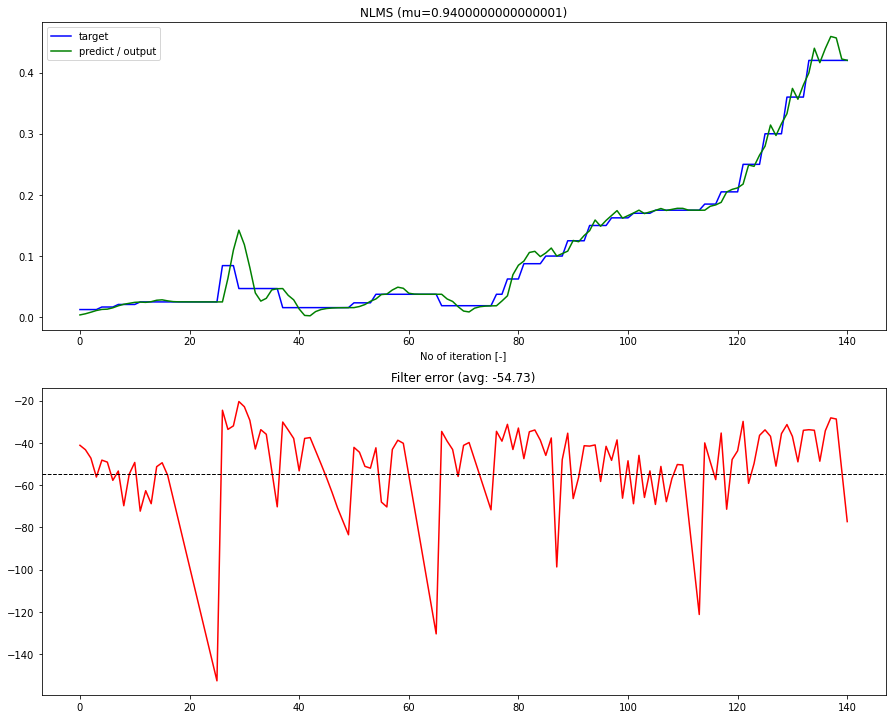

In [24]:
plot_filter_result(pred=y, actual=d, error=e, mu_val=best_mu, n=n)

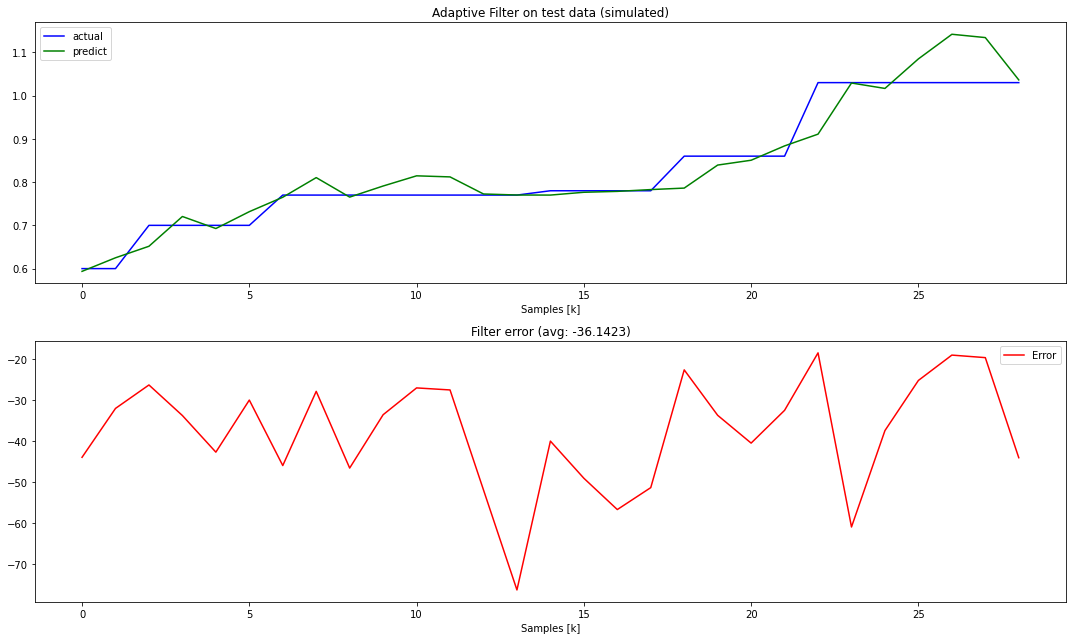

In [25]:
x_test = np.squeeze(pa.input_from_history(test, n))
d_test = np.zeros(len(x_test))
N_test = len(x_test)
for i, k in enumerate(range((n-1), N_test)):
    d_test[i] = test[k+1]

actual = np.zeros(N_test)
predict = np.zeros(N_test)

# Simulate real-time prediction and update the filter
for k in range(N_test):
    x_input = x_test[k]
    y = f.predict(x_input)
    d_actual = d_test[k]
    f.adapt(d_actual, x_input)
    actual[k] = d_actual
    predict[k] = y
    
## show results
avg_error = np.round(np.mean(10*np.log10((actual -predict)**2)), 4)
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on test data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
plt.legend()
plt.subplot(212)
plt.title(f'Filter error (avg: {avg_error})')
plt.xlabel("Samples [k]")
plt.plot(10*np.log10((actual[n: (len(actual)-n)] - \
                      predict[n: (len(predict)-n)])**2), 
         "r", label="Error")
plt.legend()
plt.tight_layout()
plt.show()

In [31]:
def predict_future(test, preds, n=5):
    x_future = np.squeeze(pa.input_from_history(test, n))
    N_future = len(x_future) + preds
    d_future = np.zeros(N_future)
    
    for i, k in enumerate(range((n-1), len(x_future))):
        d_future[i] = test[k+1]

    actual = np.zeros(len(x_future))
    predict = np.zeros(N_future)
    
    future = x_future[-1]
    for k in range(N_future):
        if k >= len(x_future):    
            future = np.delete(future, 0)
            future = np.append(future, predict[k-1])
            y = f.predict(future)
            predict[k] = y
        else:
            x_input = x_future[k]
            y = f.predict(x_input)
            predict[k] = y
            d_actual = d_future[k]
            f.adapt(d_actual, x_input)
            actual[k] = d_actual
            predict[k] = y
    return actual, predict

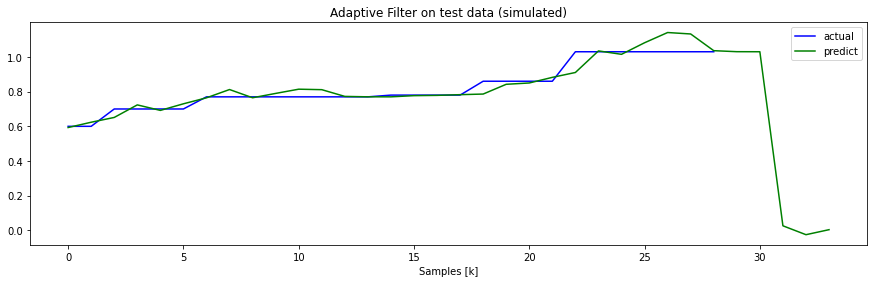

[0.52536847 0.68247206 0.36600679 0.04585631 0.12039705]


In [32]:
actual, predict = predict_future(test, 5)

## show results
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on test data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
plt.legend()
plt.show()
print(predict[-5:])

In [33]:
x_test = np.squeeze(pa.input_from_history(test, n))
d_test = np.zeros(len(x_test))
N_test = len(x_test)

In [ ]:
x_test[-1]

In [ ]:
future = x_test[-1]
future

In [ ]:
future = np.delete(future, 0)
future = np.append(future, 1)
future

In [80]:
pa.filters.FILTER_CLASSES

[padasip.filters.ap.FilterAP,
 padasip.filters.gngd.FilterGNGD,
 padasip.filters.llncosh.FilterLlncosh,
 padasip.filters.lmf.FilterLMF,
 padasip.filters.lms.FilterLMS,
 padasip.filters.nlmf.FilterNLMF,
 padasip.filters.nlms.FilterNLMS,
 padasip.filters.nsslms.FilterNSSLMS,
 padasip.filters.rls.FilterRLS,
 padasip.filters.sslms.FilterSSLMS]

In [86]:
'NLMS' in pa.filters.FILTERS.keys()

True